In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})
%matplotlib inline
from math import sqrt
import pickle
import math

#Scikit-Learn Importing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.svm import SVR
from scipy.stats.mstats import gmean, kurtosis, skew

#Import PyWavelets for WaveSmoothing
import pywt
import mad
from statsmodels import robust

#Import Keras
import keras
from keras.layers import Input, Dense, BatchNormalization, Dropout, LSTM, RepeatVector, TimeDistributed
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, Adadelta
from tqdm import tqdm
from keras.callbacks import History 
history = History()
from keras import backend as K

#Import Gridsearch
from hypopt import GridSearch

#Import Yfinance
import yfinance as yf

#Import Capstone Functions
from Capstone_Functions import *
cf = CapstoneFunctions()

#Import PyFolio
#import pyfolio as pf

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [2]:
data = pd.read_excel('EqualSectorsDaily.xlsx', index_col="date")
data2 = data.copy()

# Daily Top 3 Momentum EFT Portfolio

In [3]:
Daily = data.pct_change().dropna()

DailyLookback = data.pct_change(periods=242)
DailyLookback = DailyLookback.shift(22).dropna()
DailyLookback.head()

#Could Be better momentum strategy
#returns3 = data.pct_change(periods=12)
#returns3 = returns3.shift(1).dropna()

,Energy,Financials,Industrials,Materials,Utilities,Consumer Disc,Communication,Consumer Stap,Health,Tech
date,,,,,,,,,,
1991-01-03,-0.011036,-0.241256,-0.157329,-0.169327,-0.028862,-0.251019,-0.155433,0.057612,0.136870,-0.174986
1991-01-04,-0.020345,-0.202999,-0.142388,-0.158347,-0.028664,-0.238031,-0.150538,0.070062,0.145982,-0.148868
1991-01-07,-0.038110,-0.226415,-0.155946,-0.170699,-0.043228,-0.253214,-0.162532,0.061251,0.126303,-0.179725
1991-01-08,-0.032220,-0.240815,-0.155404,-0.176075,-0.040742,-0.254940,-0.152416,0.063365,0.121969,-0.180252
1991-01-09,-0.020090,-0.232779,-0.150922,-0.170549,-0.026512,-0.245615,-0.123450,0.071223,0.143583,-0.172924


In [4]:
def ETFSelector (data, Range1, Range2, Range3, Range4):
    df = data.T.copy()
    
    for clmn in df.columns:
        df[clmn] = df[clmn].rank(method='max')
    df
    
    df2 = df.T.copy()
    
    high1=[]
    high2=[]
    high3=[]
    high4=[]
    
    for x in range(len(df2)):
        tmp1 = (df2 == Range1).idxmax(axis=1)[x]
        high1.append(tmp1)
        tmp2 = (df2 == Range2).idxmax(axis=1)[x]
        high2.append(tmp2)
        tmp3 = (df2 == Range3).idxmax(axis=1)[x]
        high3.append(tmp3)
        tmp4 = (df2 == Range4).idxmax(axis=1)[x]
        high4.append(tmp4)
    df2['high1'] = high1
    df2['high2'] = high2
    df2['high3'] = high3
    df2['high4'] = high4
    return df2

In [5]:
def hLookup (RankedReturns, Column, RawData):
    
    '''RankedReturns is output of ETFselector function
    Column is the column name hlookup will be used on and then named
    RawData is the raw excel data'''
    
    high = RankedReturns.loc[:,Column].copy()
    
    returnshigh = RawData.pct_change().dropna()
    
    returnshigh = returnshigh.join(high,how='outer')
    returnshigh = returnshigh.dropna()
    returnshigh[Column] = returnshigh.lookup(returnshigh.index, returnshigh[Column])
    returnshigh = returnshigh[Column].copy()
    return returnshigh

In [6]:
DailyRank = ETFSelector(DailyLookback, 10.0, 9.0, 8.0, 7.0)
DailyRank.head()

,Energy,Financials,Industrials,Materials,Utilities,Consumer Disc,Communication,Consumer Stap,Health,Tech,high1,high2,high3,high4
date,,,,,,,,,,,,,,
1991-01-03,8.0,2.0,5.0,4.0,7.0,1.0,6.0,9.0,10.0,3.0,Health,Consumer Stap,Energy,Utilities
1991-01-04,8.0,2.0,6.0,3.0,7.0,1.0,4.0,9.0,10.0,5.0,Health,Consumer Stap,Energy,Utilities
1991-01-07,8.0,2.0,6.0,4.0,7.0,1.0,5.0,9.0,10.0,3.0,Health,Consumer Stap,Energy,Utilities
1991-01-08,8.0,2.0,5.0,4.0,7.0,1.0,6.0,9.0,10.0,3.0,Health,Consumer Stap,Energy,Utilities
1991-01-09,8.0,2.0,5.0,4.0,7.0,1.0,6.0,9.0,10.0,3.0,Health,Consumer Stap,Energy,Utilities


In [7]:
Daily['high1'] = hLookup (DailyRank, 'high1', data)
Daily['high2'] = hLookup (DailyRank, 'high2', data)
Daily['high3'] = hLookup (DailyRank, 'high3', data)
Daily['high4'] = hLookup (DailyRank, 'high4', data)
Daily['WODaily'] = (Daily['high1']+Daily['high2']+Daily['high3'])/3
Daily = Daily.dropna()
Daily.head()

,Energy,Financials,Industrials,Materials,Utilities,Consumer Disc,Communication,Consumer Stap,Health,Tech,high1,high2,high3,high4,WODaily
date,,,,,,,,,,,,,,,
1991-01-03,-0.014665,-0.010036,-0.007054,-0.010480,-0.006750,-0.014564,-0.012848,-0.018737,-0.027283,-0.018700,-0.027283,-0.018737,-0.014665,-0.006750,-0.020228
1991-01-04,-0.011025,0.001443,0.002016,-0.000797,-0.000209,0.004441,-0.000678,-0.001375,-0.009450,0.001095,-0.009450,-0.001375,-0.011025,-0.000209,-0.007284
1991-01-07,-0.004330,-0.024948,-0.015137,-0.012992,-0.013506,-0.023112,-0.021163,-0.019013,-0.018188,-0.018865,-0.018188,-0.019013,-0.004330,-0.013506,-0.013844
1991-01-08,0.003362,-0.013687,-0.006596,0.002592,0.002871,0.000533,-0.000485,-0.000220,-0.002338,-0.004633,-0.002338,-0.000220,0.003362,0.002871,0.000268
1991-01-09,-0.015771,-0.008949,-0.016415,-0.013431,-0.009854,-0.012127,-0.012618,-0.012969,-0.008620,-0.010883,-0.008620,-0.012969,-0.015771,-0.009854,-0.012453


# Monthly Top 3 Momentum EFT Portfolio

In [8]:
MonthlyData = data.copy()
MonthlyData = MonthlyData.resample('BMS').first()

Monthly = MonthlyData.pct_change()

MonthlyLookback = MonthlyData.pct_change(periods=11)
MonthlyLookback = MonthlyLookback.shift(1).dropna()
MonthlyLookback.head()

#Could Be better momentum strategy
#returns3 = data.pct_change(periods=12)
#returns3 = returns3.shift(1).dropna()

,Energy,Financials,Industrials,Materials,Utilities,Consumer Disc,Communication,Consumer Stap,Health,Tech
date,,,,,,,,,,
1990-12-03,-0.006452,-0.376033,-0.217317,-0.228070,-0.041087,-0.338653,-0.123741,-0.008942,0.030532,-0.299293
1991-01-01,-0.006989,-0.264233,-0.163016,-0.172411,-0.034946,-0.257216,-0.159564,0.049802,0.131522,-0.180730
1991-02-01,-0.002974,-0.154523,-0.087205,-0.058833,0.016499,-0.146022,-0.020016,0.198151,0.248600,-0.133953
1991-03-01,-0.076679,-0.106490,-0.004098,-0.025197,-0.009220,-0.055152,-0.024920,0.242614,0.331841,-0.012531
1991-04-01,0.021204,0.056419,0.056156,0.020820,0.070134,-0.011455,-0.025269,0.296063,0.463055,0.020756


In [9]:
MonthlyRank = ETFSelector(MonthlyLookback, 10.0, 9.0, 8.0, 7.0)
MonthlyRank.head()

,Energy,Financials,Industrials,Materials,Utilities,Consumer Disc,Communication,Consumer Stap,Health,Tech,high1,high2,high3,high4
date,,,,,,,,,,,,,,
1990-12-03,9.0,1.0,5.0,4.0,7.0,2.0,6.0,8.0,10.0,3.0,Health,Energy,Consumer Stap,Utilities
1991-01-01,8.0,1.0,5.0,4.0,7.0,2.0,6.0,9.0,10.0,3.0,Health,Consumer Stap,Energy,Utilities
1991-02-01,7.0,1.0,4.0,5.0,8.0,2.0,6.0,9.0,10.0,3.0,Health,Consumer Stap,Utilities,Energy
1991-03-01,2.0,1.0,8.0,4.0,7.0,3.0,5.0,9.0,10.0,6.0,Health,Consumer Stap,Industrials,Utilities
1991-04-01,5.0,7.0,6.0,4.0,8.0,2.0,1.0,9.0,10.0,3.0,Health,Consumer Stap,Utilities,Financials


In [10]:
Monthly['high1'] = hLookup (MonthlyRank, 'high1', MonthlyData)
Monthly['high2'] = hLookup (MonthlyRank, 'high2', MonthlyData)
Monthly['high3'] = hLookup (MonthlyRank, 'high3', MonthlyData)
Monthly['high4'] = hLookup (MonthlyRank, 'high4', MonthlyData)
Monthly['WOMonthly'] = (Monthly['high1']+Monthly['high2']+Monthly['high3'])/3
Monthly = Monthly.dropna()
Monthly.head()

,Energy,Financials,Industrials,Materials,Utilities,Consumer Disc,Communication,Consumer Stap,Health,Tech,high1,high2,high3,high4,WOMonthly
date,,,,,,,,,,,,,,,
1990-12-03,-0.000541,0.179176,0.069378,0.072104,0.006403,0.123139,-0.040882,0.059274,0.097998,0.169204,0.097998,-0.000541,0.059274,0.006403,0.052244
1991-01-01,-0.035078,0.031305,0.032253,0.054023,-0.002844,0.039543,0.015420,0.037224,0.031685,0.023175,0.031685,0.037224,-0.035078,-0.002844,0.011277
1991-02-01,-0.035970,0.096062,0.130220,0.045415,-0.029905,0.123791,0.002885,0.022998,0.052624,0.159803,0.052624,0.022998,-0.029905,-0.035970,0.015239
1991-03-01,0.121278,0.146707,0.085108,0.068049,0.063290,0.089089,0.043245,0.090357,0.113918,0.090721,0.113918,0.090357,0.085108,0.063290,0.096461
1991-04-01,-0.054340,0.014004,-0.023741,-0.006566,-0.001881,0.019492,0.003233,0.046828,0.034751,0.067485,0.034751,0.046828,-0.001881,0.014004,0.026566


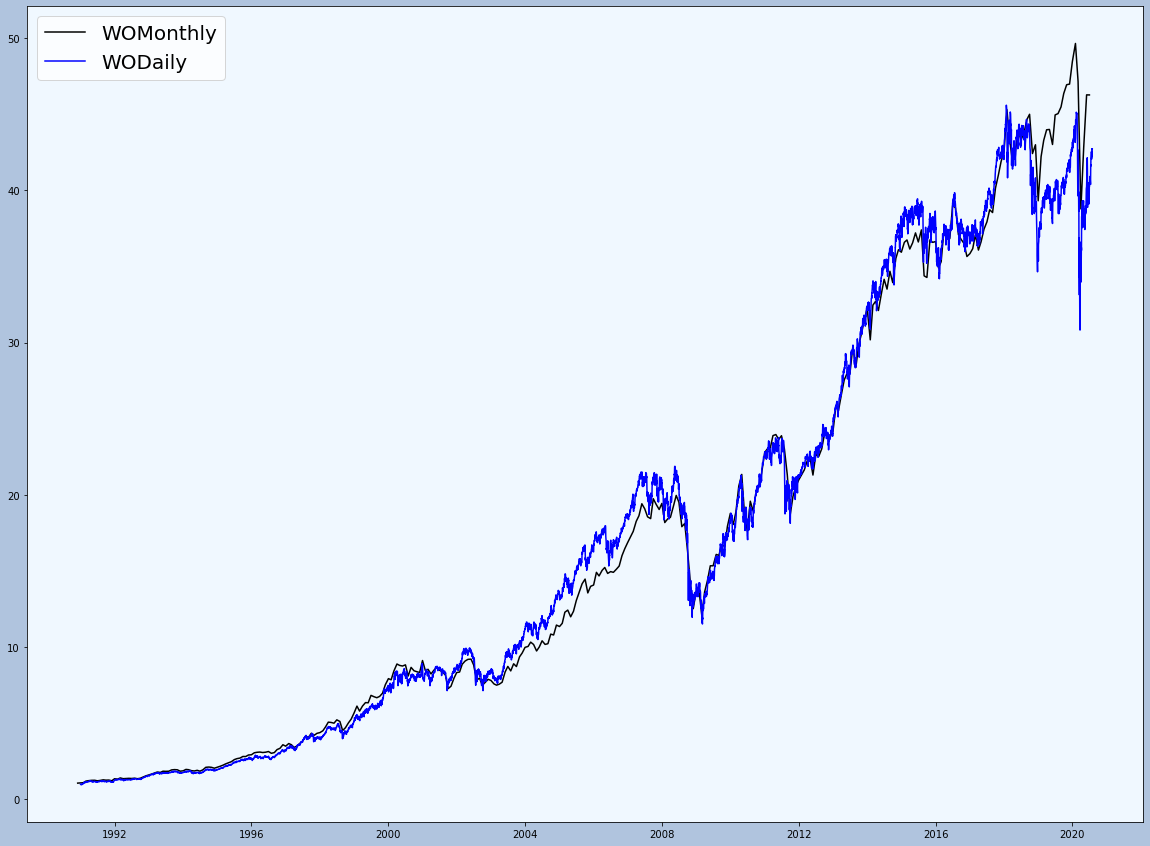

In [11]:
Monthly2 = Monthly.copy()

Monthly2['WOtmp']=Monthly2['WOMonthly']+1
Monthly2['WOcum']=np.cumprod(Monthly2['WOtmp'].iloc[0:]) 

Monthly4 = Daily.copy()

Monthly4['WOtmp']=Monthly4['WODaily']+1
Monthly4['WOcum']=np.cumprod(Monthly4['WOtmp'].iloc[0:]) 



plt.figure(figsize=(20,15)).patch.set_facecolor('lightsteelblue')
ax = plt.axes()
ax.set_facecolor("aliceblue")
plt.rcParams.update({'font.size': 20})

plt.plot((Monthly2['WOcum'].iloc[0:]), 'k', label='WOMonthly')
plt.plot((Monthly4['WOcum'].iloc[0:]), 'b', label='WODaily')
plt.legend()
plt.show()

# Create Daily FIP Top 3 ETF Portfolio

In [12]:
SandP = pd.read_excel('SandP.xlsx', index_col="date")
SandP = SandP.copy()
SandPreturns = SandP.pct_change().dropna()
SandPreturns = SandPreturns
SandPreturns.head()

,sandp
date,
1990-01-01,0.000000
1990-01-02,0.019694
1990-01-03,-0.002720
1990-01-04,-0.006567
1990-01-05,-0.005490


In [13]:
FIPDaily = data.pct_change().dropna()

FIPDaily2 = FIPDaily.subtract(SandPreturns.values,axis='columns')

FIPDaily2[FIPDaily2>0]=1
FIPDaily2[FIPDaily2<=0]=0

FIPDaily2 = FIPDaily2.rolling(242).sum()
FIPDaily2 = FIPDaily2.div(242).multiply(100)
FIPDaily2 = FIPDaily2.shift(22)
FIPDaily2 = FIPDaily2.dropna()
FIPDaily2 = FIPDaily2.iloc[:,0:10]
FIPDaily2.head()

,Energy,Financials,Industrials,Materials,Utilities,Consumer Disc,Communication,Consumer Stap,Health,Tech
date,,,,,,,,,,
1991-01-03,51.652893,39.669421,47.933884,48.760331,52.892562,40.082645,49.586777,56.198347,58.264463,49.586777
1991-01-04,51.652893,40.082645,47.933884,48.760331,52.892562,40.082645,49.586777,56.198347,58.264463,50.000000
1991-01-07,51.652893,40.082645,47.933884,48.760331,52.892562,40.082645,49.586777,56.611570,58.264463,49.586777
1991-01-08,51.652893,39.669421,47.933884,48.347107,52.892562,40.082645,50.000000,57.024793,58.264463,49.586777
1991-01-09,51.652893,39.669421,47.520661,48.347107,52.892562,40.495868,50.413223,57.024793,58.677686,49.173554


In [14]:
FIPDaily2['high1'] = DailyRank['high1'].copy()
FIPDaily2['high2'] = DailyRank['high2'].copy()
FIPDaily2['high3'] = DailyRank['high3'].copy()
FIPDaily2['high4'] = DailyRank['high4'].copy()
FIPDaily2.head()

,Energy,Financials,Industrials,Materials,Utilities,Consumer Disc,Communication,Consumer Stap,Health,Tech,high1,high2,high3,high4
date,,,,,,,,,,,,,,
1991-01-03,51.652893,39.669421,47.933884,48.760331,52.892562,40.082645,49.586777,56.198347,58.264463,49.586777,Health,Consumer Stap,Energy,Utilities
1991-01-04,51.652893,40.082645,47.933884,48.760331,52.892562,40.082645,49.586777,56.198347,58.264463,50.000000,Health,Consumer Stap,Energy,Utilities
1991-01-07,51.652893,40.082645,47.933884,48.760331,52.892562,40.082645,49.586777,56.611570,58.264463,49.586777,Health,Consumer Stap,Energy,Utilities
1991-01-08,51.652893,39.669421,47.933884,48.347107,52.892562,40.082645,50.000000,57.024793,58.264463,49.586777,Health,Consumer Stap,Energy,Utilities
1991-01-09,51.652893,39.669421,47.520661,48.347107,52.892562,40.495868,50.413223,57.024793,58.677686,49.173554,Health,Consumer Stap,Energy,Utilities


In [15]:
FIPDaily2['1'] = FIPDaily2.lookup(FIPDaily2.index, FIPDaily2['high1'])
FIPDaily2['2'] = FIPDaily2.lookup(FIPDaily2.index, FIPDaily2['high2'])
FIPDaily2['3'] = FIPDaily2.lookup(FIPDaily2.index, FIPDaily2['high3'])
FIPDaily2['4'] = FIPDaily2.lookup(FIPDaily2.index, FIPDaily2['high4'])
FIPtopDaily = FIPDaily2.iloc[:,14:19]
FIPtopDaily.head()

,1,2,3,4
date,,,,
1991-01-03,58.264463,56.198347,51.652893,52.892562
1991-01-04,58.264463,56.198347,51.652893,52.892562
1991-01-07,58.264463,56.611570,51.652893,52.892562
1991-01-08,58.264463,57.024793,51.652893,52.892562
1991-01-09,58.677686,57.024793,51.652893,52.892562


In [16]:
FIPtopDaily2 = ETFSelector (FIPtopDaily, 4.0, 3.0, 2.0, 1.0)

In [17]:
FIPtopDaily3 = FIPtopDaily2.iloc[:,4:7]
FIPtopDaily3.tail()

,high1,high2,high3
date,,,
2020-07-27,2,1,4
2020-07-28,2,1,4
2020-07-29,2,1,4
2020-07-30,2,1,4
2020-07-31,2,1,4


In [18]:
FIPtopDaily3 = FIPtopDaily3.astype(float)
FIPtopDaily3[FIPtopDaily3==1.0]=10.0
FIPtopDaily3[FIPtopDaily3==2.0]=9.0
FIPtopDaily3[FIPtopDaily3==3.0]=8.0
FIPtopDaily3[FIPtopDaily3==4.0]=7.0
FIPtopDaily3.head()

,high1,high2,high3
date,,,
1991-01-03,10.0,9.0,7.0
1991-01-04,10.0,9.0,7.0
1991-01-07,10.0,9.0,7.0
1991-01-08,10.0,9.0,7.0
1991-01-09,10.0,9.0,7.0


In [19]:
DailyRank2 = DailyRank.iloc[:,0:10].copy()
DailyRank2.head()

,Energy,Financials,Industrials,Materials,Utilities,Consumer Disc,Communication,Consumer Stap,Health,Tech
date,,,,,,,,,,
1991-01-03,8.0,2.0,5.0,4.0,7.0,1.0,6.0,9.0,10.0,3.0
1991-01-04,8.0,2.0,6.0,3.0,7.0,1.0,4.0,9.0,10.0,5.0
1991-01-07,8.0,2.0,6.0,4.0,7.0,1.0,5.0,9.0,10.0,3.0
1991-01-08,8.0,2.0,5.0,4.0,7.0,1.0,6.0,9.0,10.0,3.0
1991-01-09,8.0,2.0,5.0,4.0,7.0,1.0,6.0,9.0,10.0,3.0


In [20]:
x = DailyRank2.copy()
y = FIPtopDaily3.copy()
y = y.reset_index()
DailyReturns = Daily.copy()

FIP1 = y['high1'].copy()
FIP2 = y['high2'].copy()
FIP3 = y['high3'].copy()

high1=[]
high2=[]
high3=[]
for p in range(len(x)):
    tmp1 = (x == FIP1[p]).idxmax(axis=1)[p]
    high1.append(tmp1)
    tmp2 = (x == FIP2[p]).idxmax(axis=1)[p]
    high2.append(tmp2)
    tmp3 = (x == FIP3[p]).idxmax(axis=1)[p]
    high3.append(tmp3)
    
DailyReturns['high1'] = high1
DailyReturns['high2'] = high2
DailyReturns['high3'] = high3
DailyReturns.head()

,Energy,Financials,Industrials,Materials,Utilities,Consumer Disc,Communication,Consumer Stap,Health,Tech,high1,high2,high3,high4,WODaily
date,,,,,,,,,,,,,,,
1991-01-03,-0.014665,-0.010036,-0.007054,-0.010480,-0.006750,-0.014564,-0.012848,-0.018737,-0.027283,-0.018700,Health,Consumer Stap,Utilities,-0.006750,-0.020228
1991-01-04,-0.011025,0.001443,0.002016,-0.000797,-0.000209,0.004441,-0.000678,-0.001375,-0.009450,0.001095,Health,Consumer Stap,Utilities,-0.000209,-0.007284
1991-01-07,-0.004330,-0.024948,-0.015137,-0.012992,-0.013506,-0.023112,-0.021163,-0.019013,-0.018188,-0.018865,Health,Consumer Stap,Utilities,-0.013506,-0.013844
1991-01-08,0.003362,-0.013687,-0.006596,0.002592,0.002871,0.000533,-0.000485,-0.000220,-0.002338,-0.004633,Health,Consumer Stap,Utilities,0.002871,0.000268
1991-01-09,-0.015771,-0.008949,-0.016415,-0.013431,-0.009854,-0.012127,-0.012618,-0.012969,-0.008620,-0.010883,Health,Consumer Stap,Utilities,-0.009854,-0.012453


In [21]:
DailyReturns['FinalFip1'] = DailyReturns.lookup(DailyReturns.index, DailyReturns['high1'])
DailyReturns['FinalFip2'] = DailyReturns.lookup(DailyReturns.index, DailyReturns['high2'])
DailyReturns['FinalFip3'] = DailyReturns.lookup(DailyReturns.index, DailyReturns['high3'])

DailyReturns['FIPDaily'] = \
(DailyReturns['FinalFip1']+DailyReturns['FinalFip2']+DailyReturns['FinalFip3'])/3

# Create Monthly FIP Top 3 ETF Portfolio

In [22]:
FIPMonthly = data.pct_change().dropna()

FIPMonthly2 = FIPMonthly.subtract(SandPreturns.values,axis='columns')

FIPMonthly2[FIPMonthly2>0]=1
FIPMonthly2[FIPMonthly2<=0]=0

FIPMonthly2 = FIPMonthly2.rolling(242).sum()
FIPMonthly2 = FIPMonthly2.div(242).multiply(100)
FIPMonthly2 = FIPMonthly2.shift(22)
FIPMonthly2 = FIPMonthly2.dropna()
FIPMonthly2 = FIPMonthly2.iloc[:,0:10]
FIPMonthly2 = FIPMonthly2.resample('BMS').first()
FIPMonthly2.head()

,Energy,Financials,Industrials,Materials,Utilities,Consumer Disc,Communication,Consumer Stap,Health,Tech
date,,,,,,,,,,
1991-01-01,51.652893,39.669421,47.933884,48.760331,52.892562,40.082645,49.586777,56.198347,58.264463,49.586777
1991-02-01,49.586777,40.082645,45.454545,49.173554,50.826446,42.975207,50.413223,58.264463,56.198347,47.520661
1991-03-01,45.867769,40.082645,47.520661,48.347107,49.173554,45.454545,50.000000,57.438017,58.677686,48.760331
1991-04-01,45.867769,44.214876,45.454545,47.933884,51.239669,44.628099,47.520661,57.024793,59.917355,47.933884
1991-05-01,42.148760,43.801653,42.561983,47.520661,51.239669,46.280992,44.628099,55.785124,58.264463,49.586777


In [23]:
FIPMonthly2['high1'] = MonthlyRank['high1'].copy()
FIPMonthly2['high2'] = MonthlyRank['high2'].copy()
FIPMonthly2['high3'] = MonthlyRank['high3'].copy()
FIPMonthly2['high4'] = MonthlyRank['high4'].copy()
FIPMonthly2.head()

,Energy,Financials,Industrials,Materials,Utilities,Consumer Disc,Communication,Consumer Stap,Health,Tech,high1,high2,high3,high4
date,,,,,,,,,,,,,,
1991-01-01,51.652893,39.669421,47.933884,48.760331,52.892562,40.082645,49.586777,56.198347,58.264463,49.586777,Health,Consumer Stap,Energy,Utilities
1991-02-01,49.586777,40.082645,45.454545,49.173554,50.826446,42.975207,50.413223,58.264463,56.198347,47.520661,Health,Consumer Stap,Utilities,Energy
1991-03-01,45.867769,40.082645,47.520661,48.347107,49.173554,45.454545,50.000000,57.438017,58.677686,48.760331,Health,Consumer Stap,Industrials,Utilities
1991-04-01,45.867769,44.214876,45.454545,47.933884,51.239669,44.628099,47.520661,57.024793,59.917355,47.933884,Health,Consumer Stap,Utilities,Financials
1991-05-01,42.148760,43.801653,42.561983,47.520661,51.239669,46.280992,44.628099,55.785124,58.264463,49.586777,Health,Consumer Stap,Tech,Utilities


In [24]:
FIPMonthly2['1'] = FIPMonthly2.lookup(FIPMonthly2.index, FIPMonthly2['high1'])
FIPMonthly2['2'] = FIPMonthly2.lookup(FIPMonthly2.index, FIPMonthly2['high2'])
FIPMonthly2['3'] = FIPMonthly2.lookup(FIPMonthly2.index, FIPMonthly2['high3'])
FIPMonthly2['4'] = FIPMonthly2.lookup(FIPMonthly2.index, FIPMonthly2['high4'])
FIPtopMonthly = FIPMonthly2.iloc[:,14:19]
FIPtopMonthly.head()

,1,2,3,4
date,,,,
1991-01-01,58.264463,56.198347,51.652893,52.892562
1991-02-01,56.198347,58.264463,50.826446,49.586777
1991-03-01,58.677686,57.438017,47.520661,49.173554
1991-04-01,59.917355,57.024793,51.239669,44.214876
1991-05-01,58.264463,55.785124,49.586777,51.239669


In [25]:
FIPtopMonthly2 = ETFSelector (FIPtopMonthly, 4.0, 3.0, 2.0, 1.0)

In [26]:
FIPtopMonthly3 = FIPtopMonthly2.iloc[:,4:7]
FIPtopMonthly3.head()

,high1,high2,high3
date,,,
1991-01-01,1,2,4
1991-02-01,2,1,3
1991-03-01,1,2,4
1991-04-01,1,2,3
1991-05-01,1,2,4


In [27]:
FIPtopMonthly3 = FIPtopDaily3.astype(float)
FIPtopMonthly3[FIPtopMonthly3==1.0]=10.0
FIPtopMonthly3[FIPtopMonthly3==2.0]=9.0
FIPtopMonthly3[FIPtopMonthly3==3.0]=8.0
FIPtopMonthly3[FIPtopMonthly3==4.0]=7.0
FIPtopMonthly3.head()

,high1,high2,high3
date,,,
1991-01-03,10.0,9.0,7.0
1991-01-04,10.0,9.0,7.0
1991-01-07,10.0,9.0,7.0
1991-01-08,10.0,9.0,7.0
1991-01-09,10.0,9.0,7.0


In [28]:
MonthlyRank2 = MonthlyRank.iloc[:,0:10].copy()
MonthlyRank2.head()

,Energy,Financials,Industrials,Materials,Utilities,Consumer Disc,Communication,Consumer Stap,Health,Tech
date,,,,,,,,,,
1990-12-03,9.0,1.0,5.0,4.0,7.0,2.0,6.0,8.0,10.0,3.0
1991-01-01,8.0,1.0,5.0,4.0,7.0,2.0,6.0,9.0,10.0,3.0
1991-02-01,7.0,1.0,4.0,5.0,8.0,2.0,6.0,9.0,10.0,3.0
1991-03-01,2.0,1.0,8.0,4.0,7.0,3.0,5.0,9.0,10.0,6.0
1991-04-01,5.0,7.0,6.0,4.0,8.0,2.0,1.0,9.0,10.0,3.0


In [29]:
Monthly2 = MonthlyData.pct_change()
Monthly2 = Monthly2.loc['1990-12-03':]
Monthly2

x2 = MonthlyRank2.copy()
y2 = FIPtopMonthly3.copy()
y2 = y2.reset_index()
MonthlyReturns = Monthly2.copy()

FIP1_2 = y2['high1'].copy()
FIP2_2 = y2['high2'].copy()
FIP3_2 = y2['high3'].copy()

high1_2=[]
high2_2=[]
high3_2=[]
for p in range(len(x2)):
    tmp1_2 = (x2 == FIP1_2[p]).idxmax(axis=1)[p]
    high1_2.append(tmp1_2)
    tmp2_2 = (x2 == FIP2_2[p]).idxmax(axis=1)[p]
    high2_2.append(tmp2_2)
    tmp3_2 = (x2 == FIP3_2[p]).idxmax(axis=1)[p]
    high3_2.append(tmp3_2)
    
MonthlyReturns['high1'] = high1_2
MonthlyReturns['high2'] = high2_2
MonthlyReturns['high3'] = high3_2
MonthlyReturns.head()

,Energy,Financials,Industrials,Materials,Utilities,Consumer Disc,Communication,Consumer Stap,Health,Tech,high1,high2,high3
date,,,,,,,,,,,,,
1990-12-03,-0.000541,0.179176,0.069378,0.072104,0.006403,0.123139,-0.040882,0.059274,0.097998,0.169204,Health,Energy,Utilities
1991-01-01,-0.035078,0.031305,0.032253,0.054023,-0.002844,0.039543,0.015420,0.037224,0.031685,0.023175,Health,Consumer Stap,Utilities
1991-02-01,-0.035970,0.096062,0.130220,0.045415,-0.029905,0.123791,0.002885,0.022998,0.052624,0.159803,Health,Consumer Stap,Energy
1991-03-01,0.121278,0.146707,0.085108,0.068049,0.063290,0.089089,0.043245,0.090357,0.113918,0.090721,Health,Consumer Stap,Utilities
1991-04-01,-0.054340,0.014004,-0.023741,-0.006566,-0.001881,0.019492,0.003233,0.046828,0.034751,0.067485,Health,Consumer Stap,Financials


In [30]:
MonthlyReturns['FinalFip1'] = MonthlyReturns.lookup(MonthlyReturns.index, MonthlyReturns['high1'])
MonthlyReturns['FinalFip2'] = MonthlyReturns.lookup(MonthlyReturns.index, MonthlyReturns['high2'])
MonthlyReturns['FinalFip3'] = MonthlyReturns.lookup(MonthlyReturns.index, MonthlyReturns['high3'])

MonthlyReturns['FIPMonthly'] = \
(MonthlyReturns['FinalFip1']+MonthlyReturns['FinalFip2']+MonthlyReturns['FinalFip3'])/3

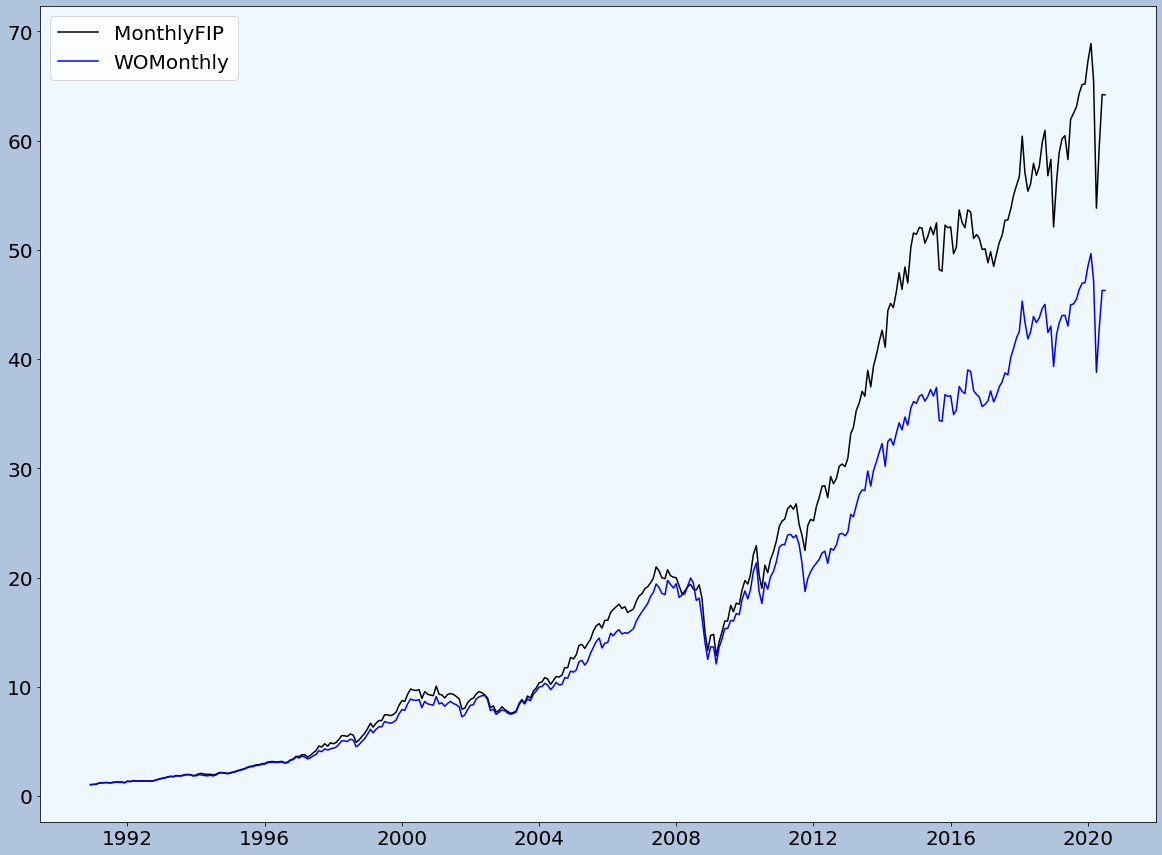

In [31]:
MonthlyReturns['WOtmp']=MonthlyReturns['FIPMonthly']+1
MonthlyReturns['WOcum']=np.cumprod(MonthlyReturns['WOtmp'].iloc[0:]) 


Monthly['WOtmp']=Monthly['WOMonthly']+1
Monthly['WOcum']=np.cumprod(Monthly['WOtmp'].iloc[0:]) 


plt.figure(figsize=(20,15)).patch.set_facecolor('lightsteelblue')
ax = plt.axes()
ax.set_facecolor("aliceblue")
plt.rcParams.update({'font.size': 20})

plt.plot((MonthlyReturns['WOcum'].iloc[0:]), 'k', label='MonthlyFIP')
plt.plot((Monthly['WOcum'].iloc[0:]), 'b', label='WOMonthly')
#plt.plot((Monthly4['WOcum'].iloc[0:]), 'c', label='DailyFIP')
plt.legend()
plt.show()

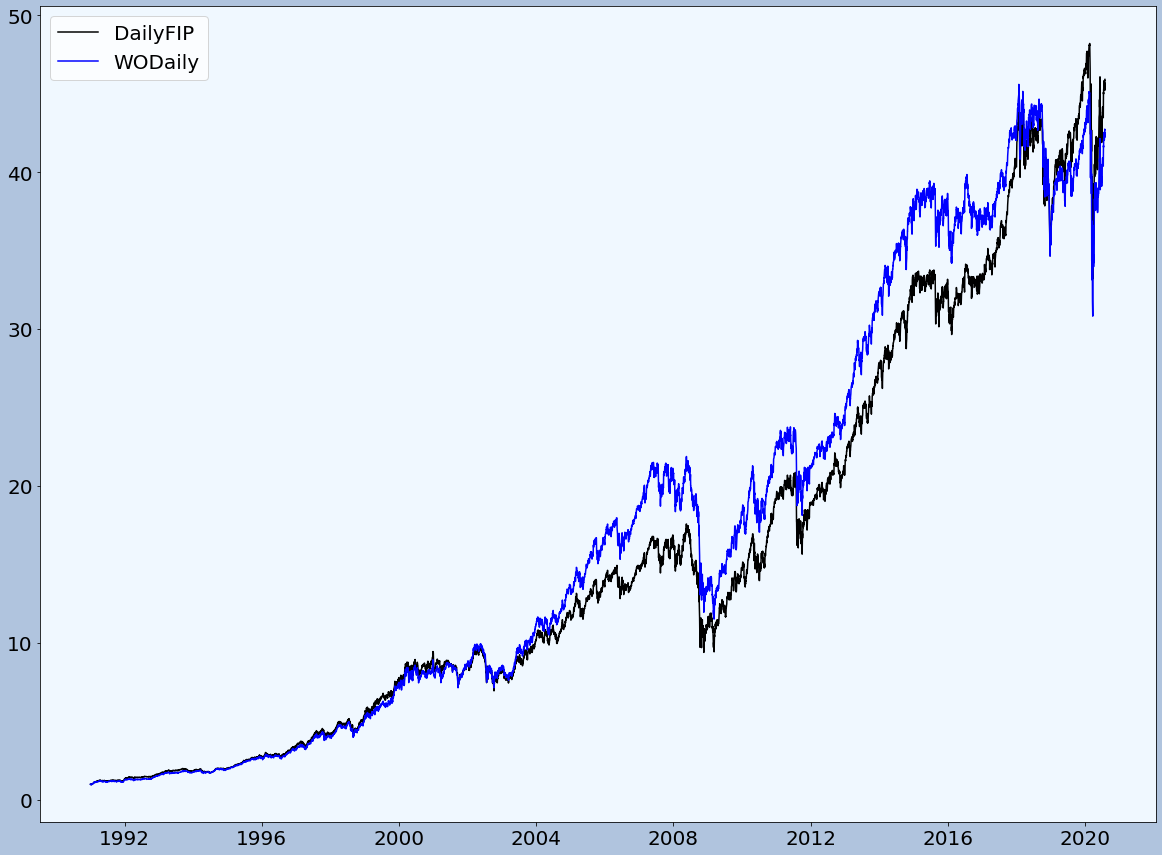

In [32]:
DailyReturns['WOtmp']=DailyReturns['FIPDaily']+1
DailyReturns['WOcum']=np.cumprod(DailyReturns['WOtmp'].iloc[0:]) 


Daily['WOtmp']=Daily['WODaily']+1
Daily['WOcum']=np.cumprod(Daily['WOtmp'].iloc[0:]) 


plt.figure(figsize=(20,15)).patch.set_facecolor('lightsteelblue')
ax = plt.axes()
ax.set_facecolor("aliceblue")
plt.rcParams.update({'font.size': 20})

plt.plot((DailyReturns['WOcum'].iloc[0:]), 'k', label='DailyFIP')
plt.plot((Daily['WOcum'].iloc[0:]), 'b', label='WODaily')
#plt.plot((Monthly4['WOcum'].iloc[0:]), 'c', label='DailyFIP')
plt.legend()
plt.show()

In [33]:
def max_drawdown(X):
    mdd = 0
    peak = X.iloc[0]
    for x in X:
        if x > peak: 
            peak = x
        dd = (peak - x) / peak
        if dd > mdd:
            mdd = dd
    return mdd

def performance_measures(inp, mkt): 
    excess=inp-mkt
    D = len(inp)
    anret=inp.add(1).prod() ** (12 / D) - 1
    anvol=inp.std()*(math.sqrt(12))
    

    print('Mean: ', inp.mean())
    print('Max: ', inp.max())
    print('Min: ', inp.min())
    print('Ann. Return: ', anret)
    print('Ann. Volatility: ', anvol)
    print('Sharpe Ratio: ', anret/anvol) 
    print('Kurtosis: ', kurtosis(inp))
    print('Skewness: ', skew(inp))
    print('MDD: ', max_drawdown((inp+1).cumprod()))

In [34]:
performance_measures(Monthly['WOMonthly'],SandPreturns)

Mean:  0.011773772599500716
Max:  0.1257219286987381
Min:  -0.177527583921558
Ann. Return:  0.1379813561828509
Ann. Volatility:  0.14974533214670532
Sharpe Ratio:  0.9214401157270847
Kurtosis:  1.7261062454297083
Skewness:  -0.7447431480543191
MDD:  0.394285129373042


In [35]:
performance_measures(MonthlyReturns['FIPMonthly'],SandPreturns)

Mean:  0.012718334868517304
Max:  0.11153943814938631
Min:  -0.177527583921558
Ann. Return:  0.15060641665565777
Ann. Volatility:  0.15098417690472146
Sharpe Ratio:  0.9974980143164136
Kurtosis:  1.959355249946924
Skewness:  -0.7252132334823228
MDD:  0.38824481048671833


In [37]:
Monthly.to_pickle('data/Monthly.pkl')
Daily.to_pickle('data/Daily.pkl')
MonthlyReturns.to_pickle('data/MonthlyReturns.pkl')